In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from tqdm import tqdm
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from src import *

/leonardo_scratch/fast/IscrC_MACRO/CalciumImagingDenoising/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PSNR and SSIM3D metrics

In [2]:
FRAMES = 300
x_path = DATASETS["synthetic"].dir / "noise_1Q_-5.52dBSNR_490x490x6000.tif"
y_path = DATASETS["synthetic"].dir / "deepcad_E_10.tif"
gt_path = DATASETS["synthetic"].dir / "clean_30Hz_490x490x6000.tif"
x, y, gt = (Recording(_, max_frames=FRAMES) for _ in [x_path, y_path, gt_path])
fft_fused = Recording(np.load("results/synthetic/fused.npy"))

In [3]:
voxel_xs = {
    "raw": x.normalized,
    "deep_cad": y.normalized,
    "fft": fft_fused.normalized,
}
voxel_y = gt.normalized

# Ensure Voxels are in [0,1] to ensure metrics homogeneity
for voxel in [voxel_y, *voxel_xs.values()]:
    assert abs(voxel.min()) < 0.01 and abs(voxel.max() - 1) < 0.01

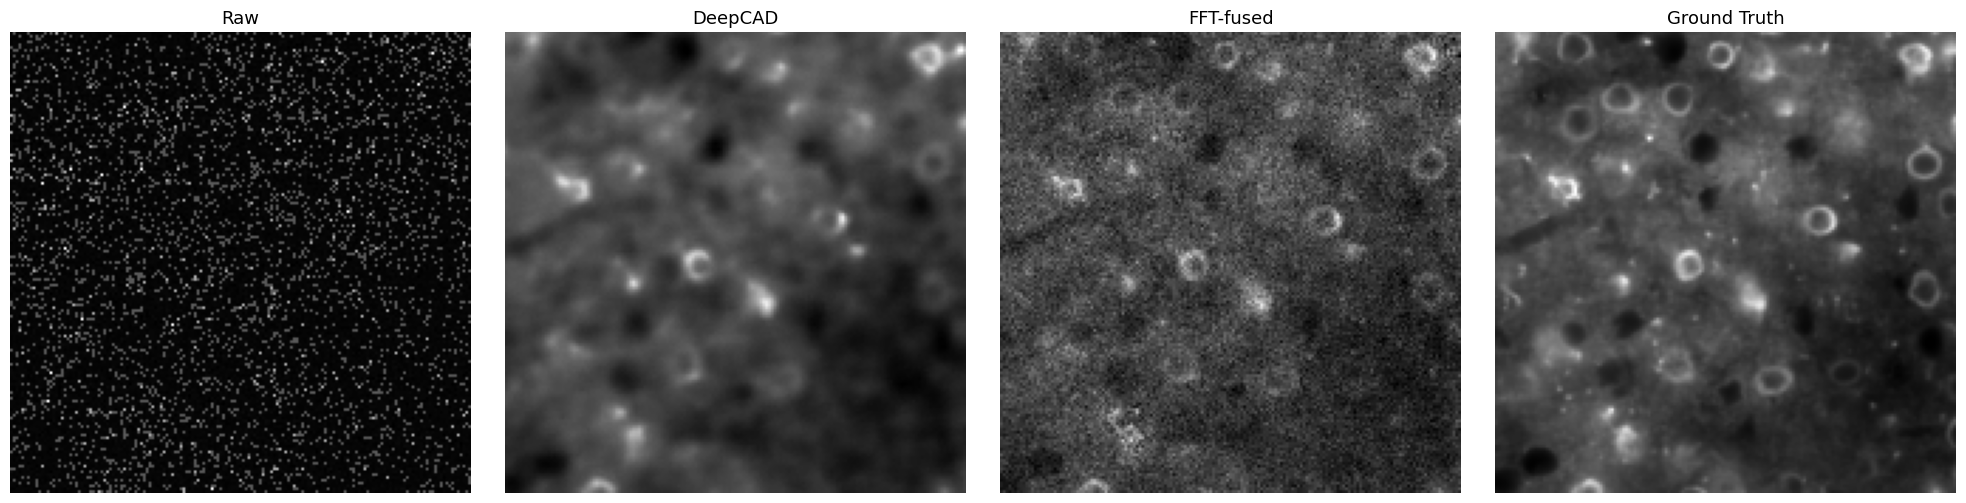

In [4]:
FRAME = 0
imshow(
    {
        "Raw": voxel_xs["raw"][FRAME],
        "DeepCAD": voxel_xs["deep_cad"][FRAME],
        "FFT-fused": voxel_xs["fft"][FRAME],
        "Ground Truth": voxel_y[FRAME],
    },
    size=5,
    zoom=3.0
)

In [5]:
psnrs = {k: psnr3d(voxel_y, v) for k, v in tqdm(voxel_xs.items())}

for k, psnr in psnrs.items():
    cprint(f"PSNR with {k} =", f"green:{psnr:.2f}dB")

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:53<00:00, 17.93s/it]

PSNR with raw = 14.22dB
PSNR with deep_cad = 25.65dB
PSNR with fft = 24.95dB


In [ ]:
STEP=32
ssims = {k: ssim3D(voxel_y[::STEP], v[::STEP]) for k, v in tqdm(voxel_xs.items())}

for k, ssim in ssims.items():
    cprint(f"PSNR with {k} =", f"green:{ssim:.2f}")

SSIM3D comparison with different step values (higher `step` means faster computation, but more coarse SSIM3D):
|STEP|Raw|Deep_cad|FFT|
|:--:|--|--|--|
|`64`|0.31|0.95|0.97|
|`32`|0.21|0.87|0.93|
|`20`|0.19|0.84|0.92|
|`16`|0.17|0.83|0.91|
|`8`|0.15|0.82|0.92|
|`4`|0.15|0.82|0.93|

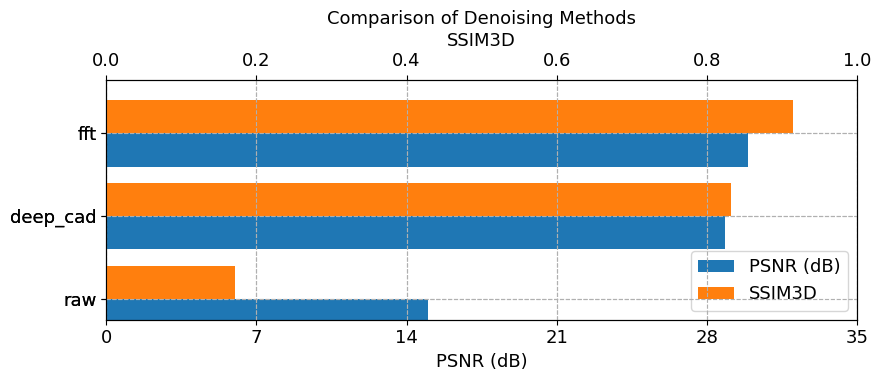

In [ ]:
df = pd.DataFrame({
    "PSNR (dB)": psnrs,
    "SSIM3D": ssims
})
fig, ax1 = plt.subplots(figsize=(9,4))

# plot PSNR
df["PSNR (dB)"].plot(kind="barh", ax=ax1, color="tab:blue", position=1, width=0.4, label="PSNR (dB)")
ax1.set_xlim(0,35)
ax1.set_xticks(range(0,36,7))
ax1.set_xlabel("PSNR (dB)")

ax2 = ax1.twiny()
df["SSIM3D"].plot(kind="barh", ax=ax2, color="tab:orange", position=0, width=0.4, label="SSIM3D")
ax2.set_xlim(0,1)
ax2.set_xlabel("SSIM3D")

ax1.set_yticks(range(len(df)))
ax1.set_yticklabels(df.index)
ax1.set_title("Comparison of Denoising Methods")

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="lower right")

plt.tight_layout()
plt.show()